In [1]:
!pip install torchsummary

In [10]:
import torch
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary

In [23]:
import torch.nn.functional as F
dropout_value = 0.1
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = NetBatchNorm().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 36, 36]             432
              ReLU-2           [-1, 16, 36, 36]               0
       BatchNorm2d-3           [-1, 16, 36, 36]              32
           Dropout-4           [-1, 16, 36, 36]               0
            Conv2d-5           [-1, 32, 36, 36]           4,608
              ReLU-6           [-1, 32, 36, 36]               0
       BatchNorm2d-7           [-1, 32, 36, 36]              64
           Dropout-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 16, 36, 36]             512
        MaxPool2d-10           [-1, 16, 18, 18]               0
           Conv2d-11           [-1, 32, 18, 18]           4,608
             ReLU-12           [-1, 32, 18, 18]               0
      BatchNorm2d-13           [-1, 32, 18, 18]              64
          Dropout-14           [-1

In [25]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [26]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


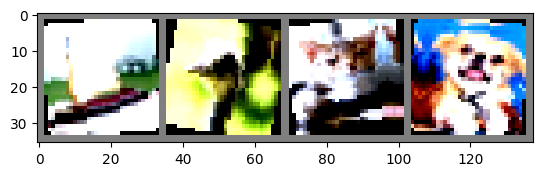

ship  bird  cat   dog  


In [28]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [34]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    misclassified_targets = []
    misclassified_predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            misclassified_mask = pred.eq(target.view_as(pred)) == 0
            misclassified_images.append(data[misclassified_mask.view(-1)])  # Flatten the mask
            misclassified_targets.append(target[misclassified_mask.view(-1)])
            misclassified_predictions.append(pred[misclassified_mask.view(-1)])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images, misclassified_targets, misclassified_predictions

In [40]:
from torch.optim.lr_scheduler import StepLR

model =  NetBatchNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    misclassified_images, misclassified_targets, misclassified_predictions = test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.5646569728851318 Batch_id=97 Accuracy=32.05: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]



Test set: Average loss: 1.8181, Accuracy: 3397/10000 (33.97%)

EPOCH: 1


Loss=1.3749325275421143 Batch_id=97 Accuracy=45.74: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 1.5197, Accuracy: 4502/10000 (45.02%)

EPOCH: 2


Loss=1.283813714981079 Batch_id=97 Accuracy=51.35: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 1.2272, Accuracy: 5592/10000 (55.92%)

EPOCH: 3


Loss=1.2508519887924194 Batch_id=97 Accuracy=54.72: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 1.1589, Accuracy: 5850/10000 (58.50%)

EPOCH: 4


Loss=1.1376656293869019 Batch_id=97 Accuracy=57.92: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 1.0612, Accuracy: 6232/10000 (62.32%)

EPOCH: 5


Loss=1.0828945636749268 Batch_id=97 Accuracy=59.76: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 1.1279, Accuracy: 6004/10000 (60.04%)

EPOCH: 6


Loss=1.0654650926589966 Batch_id=97 Accuracy=61.35: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.9998, Accuracy: 6450/10000 (64.50%)

EPOCH: 7


Loss=1.0332682132720947 Batch_id=97 Accuracy=62.64: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]



Test set: Average loss: 1.0307, Accuracy: 6328/10000 (63.28%)

EPOCH: 8


Loss=0.9855612516403198 Batch_id=97 Accuracy=63.66: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 1.0057, Accuracy: 6423/10000 (64.23%)

EPOCH: 9


Loss=1.0151270627975464 Batch_id=97 Accuracy=64.65: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.9005, Accuracy: 6814/10000 (68.14%)

EPOCH: 10


Loss=0.8695366382598877 Batch_id=97 Accuracy=65.08: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.9158, Accuracy: 6786/10000 (67.86%)

EPOCH: 11


Loss=0.9140108823776245 Batch_id=97 Accuracy=65.22: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.9195, Accuracy: 6687/10000 (66.87%)

EPOCH: 12


Loss=1.019182801246643 Batch_id=97 Accuracy=66.31: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 0.8613, Accuracy: 6984/10000 (69.84%)

EPOCH: 13


Loss=0.8369536399841309 Batch_id=97 Accuracy=66.87: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.8888, Accuracy: 6907/10000 (69.07%)

EPOCH: 14


Loss=0.975836992263794 Batch_id=97 Accuracy=67.56: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.8327, Accuracy: 7057/10000 (70.57%)

EPOCH: 15


Loss=0.8432837724685669 Batch_id=97 Accuracy=68.05: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.8206, Accuracy: 7099/10000 (70.99%)

EPOCH: 16


Loss=0.9451615214347839 Batch_id=97 Accuracy=68.34: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.8163, Accuracy: 7143/10000 (71.43%)

EPOCH: 17


Loss=0.8058986663818359 Batch_id=97 Accuracy=68.67: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.8153, Accuracy: 7139/10000 (71.39%)

EPOCH: 18


Loss=0.8623785972595215 Batch_id=97 Accuracy=69.08: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 0.7787, Accuracy: 7261/10000 (72.61%)

EPOCH: 19


Loss=0.9505950212478638 Batch_id=97 Accuracy=69.48: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Test set: Average loss: 0.7636, Accuracy: 7336/10000 (73.36%)



Text(0.5, 1.0, 'Test Accuracy')

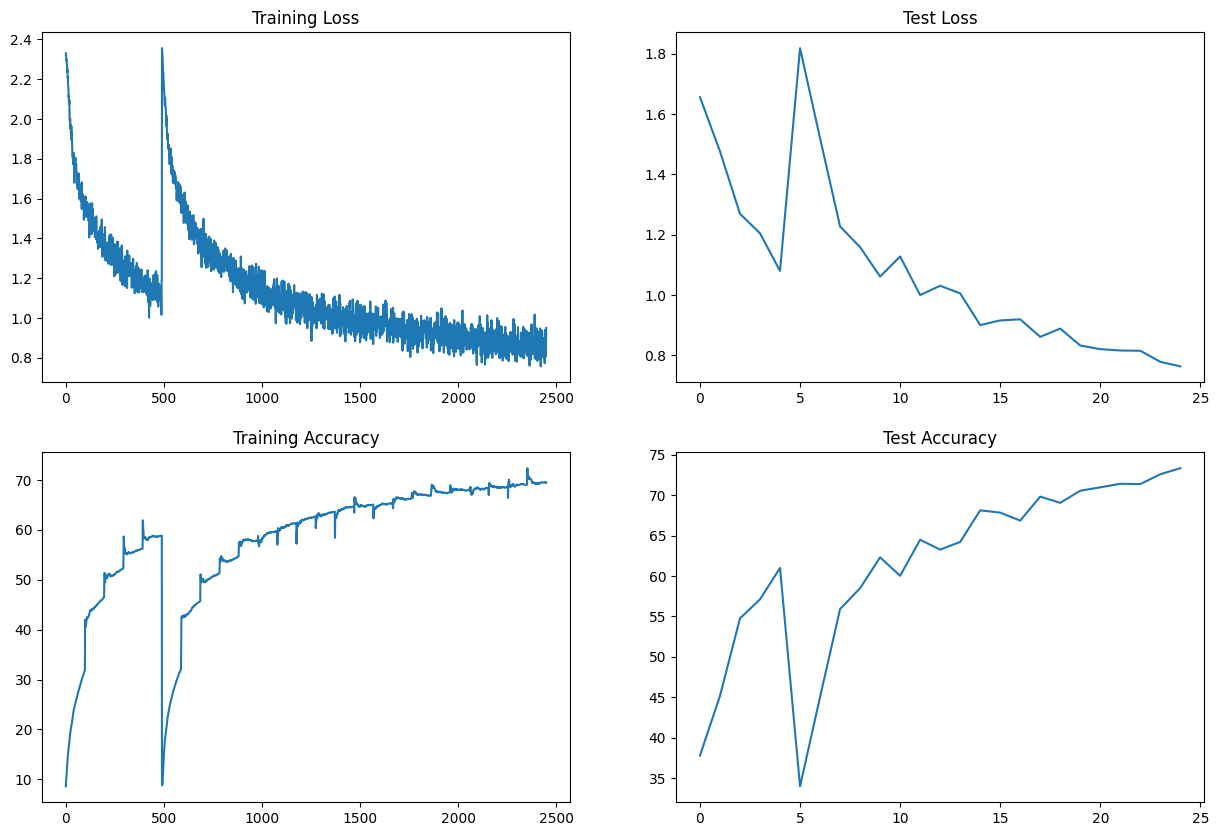

In [41]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

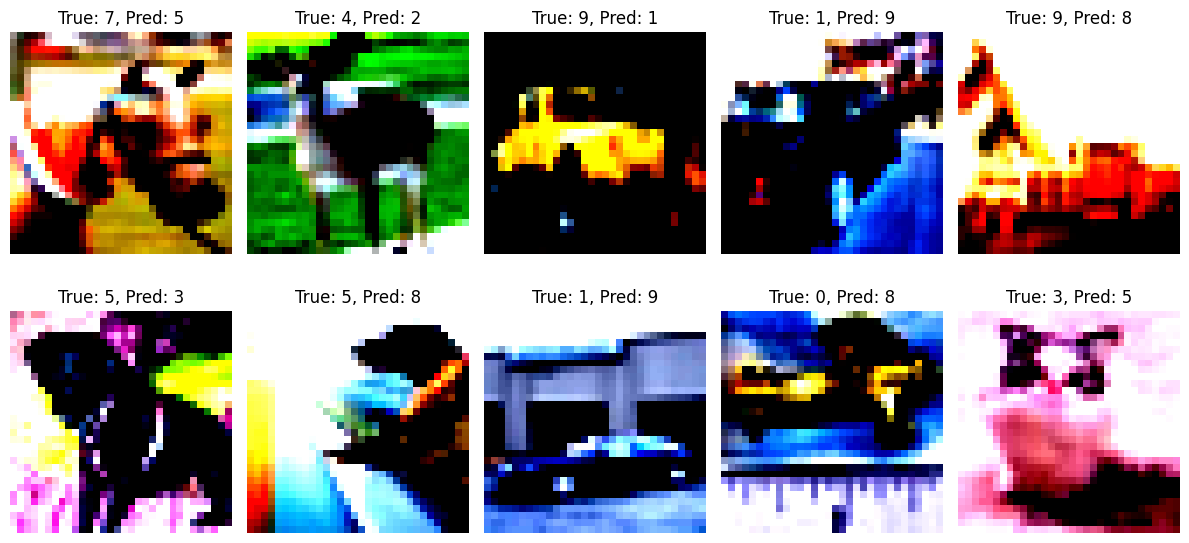

In [42]:

# Sample 10 misclassified images
num_samples = 10
sample_indices = np.random.choice(len(misclassified_images), min(num_samples, len(misclassified_images)), replace=False)

# Plot misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(sample_indices):
        ax.imshow(misclassified_images[sample_indices[i]][0].cpu().numpy().transpose((1, 2, 0)))
        ax.set_title(f"True: {misclassified_targets[sample_indices[i]][0].item()}, Pred: {misclassified_predictions[sample_indices[i]][0].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()